In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import cartopy.crs as ccrs
from pyproj import Geod
from scipy import stats
from Load_and_Process_Datasets import *
import geopandas as gpd
from palettable.colorbrewer.diverging import *
from palettable.colorbrewer.sequential import *

# Load Lat, Lon, and Elevation Data

<Figure size 432x288 with 0 Axes>

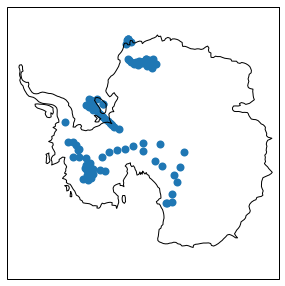

In [2]:
# Load data
lat_lon_elevation_path = "/pl/active/nasa_smb/Data/Density_Profile_Lat_Lon_Elevation.txt"
lat, lon, elevation = np.loadtxt(lat_lon_elevation_path, unpack=True)

# Plot Data
plt.figure(1)
fig1 = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines(resolution='110m')
ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
plt.scatter(lon, lat, linewidth=2, marker='o', transform=ccrs.Geodetic())

# Calculate 1980-2019 Mean MERRA-2 P-E at all sites in meters water equivalent (m.w.e.)

In [3]:
data_path = "/projects/erke2265/SOTC_AIS_SMB/nc_files/"
        
# Precipitation
sn = xr.open_mfdataset(data_path + "PRECSN_monthly_*.nc")
ls = xr.open_mfdataset(data_path + "PRECLS_monthly_*.nc")
cu = xr.open_mfdataset(data_path + "PRECCU_monthly_*.nc")

# Evaporation 
evap = xr.open_mfdataset(data_path + "EVAP_monthly_*.nc")

# Calculate SMB (P-E)
smb = (sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']) / 12 # convert to yearly average
smb = smb.sum(dim = "time") * 3.154e+7 / 1000 / (2019 - 1980 + 1) # convert to units of m.w.e/yr

# Now get P-E at each lat/lon pair
p_e = smb.sel(lon = lon, lat = lat, method = "nearest")
p_e = p_e.values.diagonal()

In [ ]:
243.77 - 273.15

-29.379999999999967

# Load Density Profiles

In [ ]:
# Open a pickle file
f = open("density_profile_10mfl_ov_rr.pkl",'rb')
density = pickle.load(f)
f.close()

# Plot a single profile

In [ ]:
for j in range(0, len(lat)):
# for j in range(0, 1):
    print(j)
    # Define index
    ind = str(j + 1)

    # Plot profile
    fig = plt.figure(figsize=(6,10))
    plt.plot(density['fdm_density_' + ind], density['fdm_depth_' + ind], 'r', \
             linewidth = 2, label = 'FDM')
    plt.plot(density['snowpack_density_' + ind], density['snowpack_depth_' + ind], 'k', \
             linewidth = 2, label = 'SNOWPACK')
    plt.plot(density['sumup_density_' + ind], density['sumup_depth_' + ind], 'b', \
             linewidth = 2, label = 'Observations')
    plt.grid()
    plt.ylim([0, 10])
    plt.gca().invert_yaxis()
    plt.legend()
    plt.ylabel("Depth [m]", fontsize = 18)
    plt.xlabel("Density [kg m$^-$$^3$]", fontsize = 18)
    plt.xlim([200, 650])
    plt.savefig('Figures/density_profiles/profile_' + ind + ".png", format='png', dpi=100)
    
    # Plot map
    plt.figure(1)
    fig1 = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.coastlines(resolution='110m')
    ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    plt.scatter(lon[j], lat[j], linewidth=2, marker='o', transform=ccrs.Geodetic())
    plt.savefig('Figures/density_profiles/map_' + ind + ".png", format='png', dpi=100)

!zip -r Figures/profiles.zip Figures/density_profiles/



0
1
2
3
4
5
6
7
8
9
10


/projects/erke2265/miniconda/envs/a3d/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/projects/erke2265/miniconda/envs/a3d/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


11
12
13
14
15
16
17
18
19
20
21
22
23
24


# Define Vertical Bins

In [ ]:
depth_interest_low = 0
depth_interest_high = 10
step = 1

# Calculate depth bin weighted (by layer thickness) density averages

In [ ]:
# Initialize arrays
depth = np.arange(depth_interest_low, depth_interest_high + step, step)
SUMup_avg = np.zeros([len(depth) - 1, len(lat)]); SUMup_avg[:] = np.nan
SUMup_avg_error = np.zeros([len(depth) - 1, len(lat)]); SUMup_avg[:] = np.nan
FDM_avg = np.zeros([len(depth) - 1, len(lat)]); FDM_avg[:] = np.nan
SNOWPACK_avg = np.zeros([len(depth) - 1, len(lat)]); SNOWPACK_avg[:] = np.nan

# Calculate average in each depth bin

# SUMup
for k in range(0, len(SUMup_avg)): # Layer
    depth_low = depth[k]
    depth_high = depth[k+1]
    filter_func = np.vectorize(lambda depth: depth >= depth_low and depth <= depth_high)
    for j in range(0, len(lat)): # Profile
        tmp_density = density["sumup_density_" + str(j+1)]
        tmp_depth = density["sumup_depth_" + str(j+1)]
        tmp_error = density["sumup_error_" + str(j+1)]
        if len(tmp_depth) == 0: # No data at all
            SUMup_avg[k,j] = np.nan
            SUMup_avg_error[k,j] = np.nan
        else: # There is data
            tmp_density_filtered = tmp_density[filter_func(tmp_depth)]
            tmp_depth_filtered = tmp_depth[filter_func(tmp_depth)]
            tmp_error_filtered = tmp_error[filter_func(tmp_depth)]
            thickness = np.zeros(len(tmp_density_filtered)); thickness[:] = np.nan
            if len(tmp_density_filtered) == 0: # No data in depth bin
                SUMup_avg[k,j] = np.nan
                SUMup_avg_error[k,j] = np.nan
            elif len(tmp_density_filtered) == 1: # Only one data point
                SUMup_avg[k,j] = tmp_density_filtered[0]
                SUMup_avg_error[k,j] = tmp_error_filtered[0]
            else: # There is data in depth bin
                for jj in range(0, len(tmp_depth_filtered)):
                    if jj == 0:
                        thickness[jj] = (tmp_depth_filtered[jj] + tmp_depth_filtered[jj+1]) / 2 - depth_low
                    elif jj == len(tmp_depth_filtered) - 1:
                        thickness[jj] = depth_high - (tmp_depth_filtered[jj] + tmp_depth_filtered[jj-1]) / 2
                    else: 
                        thickness[jj] = ((tmp_depth_filtered[jj+1] + tmp_depth_filtered[jj]) / 2) - ((tmp_depth_filtered[jj] + tmp_depth_filtered[jj-1]) / 2)
                SUMup_avg[k,j] = np.nansum(tmp_density_filtered * thickness / np.nansum(thickness))

# SUMup site 96 depth data is not sorted in order, so I throw it out.
SUMup_avg[:,95] = np.nan

# FDM
for k in range(0, len(FDM_avg)): # Layer
    depth_low = depth[k]
    depth_high = depth[k+1]
    filter_func = np.vectorize(lambda depth: depth >= depth_low and depth <= depth_high)
    for j in range(0, len(lat)): # Profile
        tmp_density = density["fdm_density_" + str(j+1)]
        tmp_depth = density["fdm_depth_" + str(j+1)]
        if len(tmp_depth) == 0: # No data at all
            FDM_avg[k,j] = np.nan
        else: # There is data
            tmp_density_filtered = tmp_density[filter_func(tmp_depth)]
            tmp_depth_filtered = tmp_depth[filter_func(tmp_depth)]
            thickness = np.zeros(len(tmp_density_filtered)); thickness[:] = np.nan
            if len(tmp_density_filtered) == 0: # No data in depth bin
                FDM_avg[k,j] = np.nan
            elif len(tmp_density_filtered) == 1: # Only one data point
                FDM_avg[k,j] = tmp_density_filtered[0]
            else: # There is data in depth bin
                for jj in range(0, len(tmp_depth_filtered)):
                    if jj == 0:
                        thickness[jj] = (tmp_depth_filtered[jj] + tmp_depth_filtered[jj+1]) / 2 - depth_low
                    elif jj == len(tmp_depth_filtered) - 1:
                        thickness[jj] = depth_high - (tmp_depth_filtered[jj] + tmp_depth_filtered[jj-1]) / 2
                    else: 
                        thickness[jj] = ((tmp_depth_filtered[jj+1] + tmp_depth_filtered[jj]) / 2) - ((tmp_depth_filtered[jj] + tmp_depth_filtered[jj-1]) / 2)
                FDM_avg[k,j] = np.nansum(tmp_density_filtered * thickness / np.nansum(thickness))     
                
# SNOWPACK
for k in range(0, len(SNOWPACK_avg)): # Layer
    depth_low = depth[k]
    depth_high = depth[k+1]
    filter_func = np.vectorize(lambda depth: depth >= depth_low and depth <= depth_high)
    for j in range(0, len(lat)): # Profile
        tmp_density = density["snowpack_density_" + str(j+1)]
        tmp_depth = density["snowpack_depth_" + str(j+1)]
        if len(tmp_depth) == 0: # No data at all
            SNOWPACK_avg[k,j] = np.nan
        else: # There is data
            tmp_density_filtered = tmp_density[filter_func(tmp_depth)]
            tmp_depth_filtered = tmp_depth[filter_func(tmp_depth)]
            thickness = np.zeros(len(tmp_density_filtered)); thickness[:] = np.nan
            if len(tmp_density_filtered) == 0: # No data in depth bin
                SNOWPACK_avg[k,j] = np.nan
            elif len(tmp_density_filtered) == 1: # Only one data point
                SNOWPACK_avg[k,j] = tmp_density_filtered[0]
            else: # There is data in depth bin
                for jj in range(0, len(tmp_depth_filtered)):
                    if jj == 0:
                        thickness[jj] = (tmp_depth_filtered[jj] + tmp_depth_filtered[jj+1]) / 2 - depth_low
                    elif jj == len(tmp_depth_filtered) - 1:
                        thickness[jj] = depth_high - (tmp_depth_filtered[jj] + tmp_depth_filtered[jj-1]) / 2
                    else: 
                        thickness[jj] = ((tmp_depth_filtered[jj+1] + tmp_depth_filtered[jj]) / 2) - ((tmp_depth_filtered[jj] + tmp_depth_filtered[jj-1]) / 2)
                SNOWPACK_avg[k,j] = np.nansum(tmp_density_filtered * thickness / np.nansum(thickness))           


# Filter layers that do not have info from both models and observations
# Also filter based of elevation of smb

In [ ]:
ind = np.zeros(SUMup_avg.shape); ind[:] = np.nan
depth = np.arange(step / 2, depth_interest_high, step)

# Loop through every profile and layer to calculate filter
for k in range(0, len(depth)): # Layer
    for j in range(0, len(lat)): # Profile
        if ~np.isnan(SUMup_avg[k,j]) and ~np.isnan(FDM_avg[k,j]) and ~np.isnan(SNOWPACK_avg[k,j]):
            ind[k,j] = 1

# ##### Elevation Filter #####
# # Elevation threshold in meters
# thresh_high = 5000
# thresh_low = 0

# plt.hist(elevation)
# plt.axvline(x=thresh_high, c='r')
# plt.axvline(x=thresh_low, c='r')

# for j in range(0, len(lat)): # Loop through all sites
#     if elevation[j] > thresh_high or elevation[j] < thresh_low:
#         ind[:,j] = np.nan
        
##### Accumulation Filter #####
# Accumulation threshold in m.w.e.
# Filter out low accumulation
thresh_high = 1
thresh_low = .2
# qualitative_description = "High Accumulation"
# Filter out high accumulation
thresh_high = .2
thresh_low = 0
# qualitative_description = "Low Accumulation"



plt.hist(p_e)
plt.axvline(x=thresh_high, c='r')
plt.axvline(x=thresh_low, c='r')

for j in range(0, len(lat)): # Loop through all sites
    if p_e[j] > thresh_high or p_e[j] < thresh_low:
        ind[:,j] = np.nan


# Determine which sites are used

In [ ]:
sites_used = np.zeros(len(lat)); sites_used[:] = np.nan # Nan means not used, 1 means used
for j in range(0, len(lat)):
    # If there is non nan in ind[:,j]
    if np.nansum(ind[:,j]) > 0:
        sites_used[j] = 1

# Apply filter

In [ ]:
# Apply filter
filter_SUMup_avg = SUMup_avg * ind
filter_FDM_avg = FDM_avg * ind
filter_SNOWPACK_avg = SNOWPACK_avg * ind

# Calculate depth averages pth
SUMup_mean = np.nanmean(filter_SUMup_avg, axis=1)
FDM_mean = np.nanmean(filter_FDM_avg, axis=1)
SNOWPACK_mean = np.nanmean(filter_SNOWPACK_avg, axis=1)

# Calculate depth standard deviations 
SUMup_std = np.nanstd(filter_SUMup_avg, axis=1)
FDM_std = np.nanstd(filter_FDM_avg, axis=1)
SNOWPACK_std = np.nanstd(filter_SNOWPACK_avg, axis=1)

# Coastline data

In [ ]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Plot 

In [ ]:
# Plot
# Plot Means
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
# fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,10))
ax1.plot(SUMup_mean, depth, 'bo--', linewidth = 2, label = 'Observations')
ax1.plot(FDM_mean, depth, 'ro--', linewidth = 2, label = 'IMAU-FDM')
ax1.plot(SNOWPACK_mean, depth, 'ko--', linewidth = 2, label = 'SNOWPACK')

# Plot standard deviations
ax1.fill_betweenx(depth, SUMup_mean - SUMup_std, SUMup_mean + SUMup_std, \
                  facecolor = "blue", color = "blue", alpha = 0.2, label = "\u00B1" + " \u03C3")
ax1.fill_betweenx(depth, FDM_mean - FDM_std, FDM_mean + FDM_std, \
                  facecolor = "red", color = "red", alpha = 0.2, label = "\u00B1" + " \u03C3")
ax1.fill_betweenx(depth, SNOWPACK_mean - SNOWPACK_std, SNOWPACK_mean + SNOWPACK_std, \
                  facecolor = "black", color = "black", alpha = 0.2, label = "\u00B1" + " \u03C3")

# Plot Dashed edges
ax1.plot(SUMup_mean - SUMup_std, depth, 'b', linewidth = 2)
ax1.plot(SUMup_mean + SUMup_std, depth, 'b', linewidth = 2)
ax1.plot(FDM_mean - FDM_std, depth, 'r', linewidth = 2)
ax1.plot(FDM_mean + FDM_std, depth, 'r', linewidth = 2)
ax1.plot(SNOWPACK_mean - SNOWPACK_std, depth, 'k', linewidth = 2)
ax1.plot(SNOWPACK_mean + SNOWPACK_std, depth, 'k', linewidth = 2)

# Plotting options
ax1.grid()
ax1.set_xlim([300, 600])
ax1.set_ylim([0, 10])
ax1.invert_yaxis()
ax1.legend(fontsize = 12)
ax1.set_ylabel("Depth [m]", fontsize = 18)
ax1.set_xlabel("Density [kg m$^-$$^3$]", fontsize = 18)
ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

# Plot bias with depth
FDM_bias = FDM_mean - SUMup_mean
SNOWPACK_bias = SNOWPACK_mean - SUMup_mean

ax2.plot(FDM_bias, depth, 'ro--', linewidth=2, label = "IMAU-FDM")
ax2.plot(SNOWPACK_bias, depth, 'ko--', linewidth=2, label = "SNOWPACK")
ax2.grid()
ax2.set_xlim([-65, 65])
ax2.set_ylim([0, 10])
ax2.invert_yaxis()
ax2.set_ylabel("Depth [m]", fontsize = 18)
ax2.set_xlabel("Density Bias [kg m$^-$$^3$]", fontsize = 18)
ax2.tick_params(axis="x", labelsize=16)
ax2.tick_params(axis="y", labelsize=16)
ax2.legend(fontsize = 12)

# Plot the number of profiles with depth
# Perform count
counts = []
for j in range(0, len(depth)):
    counts.append(np.count_nonzero(~np.isnan(ind[j,:])))

# # Plot
# ax3.plot(counts, depth, 'ko--', linewidth=2)
# ax3.grid()
# ax3.set_ylim([0, 10])
# ax3.invert_yaxis()
# ax3.set_ylabel("Depth [m]", fontsize = 18)
# ax3.set_xlabel("Number of Profiles", fontsize = 18)
# ax3.set_title("Number of profiles that have coincident Obs, FDM, and SNOWPACK with Depth")
plt.savefig("Figures/density_profile.pdf", format='pdf', dpi=100)

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot SNOWPACK minus Observations
plt.scatter(lon*sites_used, lat*sites_used, linewidth=2, c='k', marker='o', transform=ccrs.Geodetic())
plt.savefig("Figures/density_profile_map.pdf", format='pdf', dpi=100)
print(np.count_nonzero(~np.isnan(lat*sites_used)))



In [ ]:
print((SUMup_mean[0]))

In [ ]:
print((SUMup_mean))

In [ ]:
print((SNOWPACK_mean))

In [ ]:
print((SNOWPACK_bias))

In [ ]:
SNOWPACK_bias.max()

In [ ]:
print(FDM_bias)

# Investigate standard deviations

In [ ]:
SUMup_std

In [ ]:
SNOWPACK_std

In [ ]:
FDM_std

In [ ]:
plt.plot(SNOWPACK_std - SUMup_std, 'b', label='SNOWPACK')
plt.plot(FDM_std - SUMup_std, 'r', label='FDM')
plt.ylim([-30, 30])
plt.grid()
plt.legend()

# Scatter plot of SUMup vs SNOWPACK in the top meter
#### This analysis is different than what I do in `Plot_Top_Meter_Density.ipynb`

In [ ]:
domain = np.array([0, 700])
ind_snowpack = []
depth_ind = 0 # Ind must be an integer. If ind = x, then you will querry from x to x + 1 m. 

# Loop through every site
for k in range(0, len(lat)):
        if ~np.isnan(SUMup_avg[depth_ind,k]) and ~np.isnan(SNOWPACK_avg[depth_ind,k]) and ~np.isnan(FDM_avg[depth_ind,k]):
            ind_snowpack.append(k)

plt.figure(figsize=(10, 10))
plt.scatter(SUMup_avg[depth_ind,ind_snowpack], SNOWPACK_avg[depth_ind,ind_snowpack], c='k')
# plt.errorbar(SUMup_avg[depth_ind,ind_snowpack], SNOWPACK_avg[depth_ind,ind_snowpack], \
#              xerr=0.1 * SUMup_avg[depth_ind,ind_snowpack], fmt='ko')
plt.plot([0, 700], [0, 700], 'k--')
plt.xlim([250, 525])
plt.ylim([250, 525])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Observed Surface Density [kg m$^-$$^3$]', fontsize=24)
plt.ylabel('SNOWPACK Surface Density [kg m$^-$$^3$]', fontsize=24)

slope, intercept, r_value, p_value, std_err = \
    stats.linregress(SUMup_avg[depth_ind,ind_snowpack], SNOWPACK_avg[depth_ind,ind_snowpack])
plt.plot(domain, intercept + slope*domain, 'k', label='fitted line')

rmse = utilities.calc_rmse(SUMup_avg[depth_ind,ind_snowpack], SNOWPACK_avg[depth_ind,ind_snowpack])
bias = utilities.calc_bias(SUMup_avg[depth_ind,ind_snowpack], SNOWPACK_avg[depth_ind,ind_snowpack])

print("R-squared: %f" % r_value**2)
print("p-value: %f" % p_value)
print("RMSE: %f" % rmse)
print("Bias: %f" % bias)
print("Slope: %f" % slope)
plt.savefig("Figures/SNOWPACK_top_meter_density_scatter.pdf", format='pdf', dpi=100)
print(len(SNOWPACK_avg[0,ind_snowpack]))

# Calculate SNOWPACK surface density bias and rmse when observed density is larger than 400 $kgm^{-3}$

In [ ]:
rmse = utilities.calc_rmse(SUMup_avg[0,ind_snowpack][SUMup_avg[0,ind_snowpack] > 400], SNOWPACK_avg[0,ind_snowpack][SUMup_avg[0,ind_snowpack] > 400])
bias = utilities.calc_bias(SUMup_avg[0,ind_snowpack][SUMup_avg[0,ind_snowpack] > 400], SNOWPACK_avg[0,ind_snowpack][SUMup_avg[0,ind_snowpack] > 400])
print(bias)
print(rmse)

# Scatter plot of SUMup vs FDM in the top meter
#### This analysis is different than what I do in `Plot_Top_Meter_Density.ipynb`

In [ ]:
domain = np.array([0, 700])
ind_fdm = []

# Loop through every site
for k in range(0, len(lat)):
        if ~np.isnan(SUMup_avg[depth_ind,k]) and ~np.isnan(FDM_avg[depth_ind,k]) and ~np.isnan(SNOWPACK_avg[depth_ind,k]):
            ind_fdm.append(k)

plt.figure(figsize=(10, 10))
plt.scatter(SUMup_avg[depth_ind,ind_fdm], FDM_avg[depth_ind,ind_fdm], c='red')
# plt.errorbar(SUMup_avg[depth_ind,ind_fdm], FDM_avg[depth_ind,ind_fdm], \
#              xerr=0.1 * SUMup_avg[depth_ind,ind_fdm], fmt='ro')
plt.plot([0, 700], [0, 700], 'k--')
plt.xlim([250, 525])
plt.ylim([250, 525])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Observed Surface Density [kg m$^-$$^3$]', fontsize=24)
plt.ylabel('IMAU-FDM Surface Density [kg m$^-$$^3$]', fontsize=24)

slope, intercept, r_value, p_value, std_err = \
    stats.linregress(SUMup_avg[depth_ind,ind_fdm], FDM_avg[depth_ind,ind_fdm])
plt.plot(domain, intercept + slope*domain, 'r', label='fitted line')

rmse = utilities.calc_rmse(SUMup_avg[depth_ind,ind_fdm], FDM_avg[depth_ind,ind_fdm])
bias = utilities.calc_bias(SUMup_avg[depth_ind,ind_fdm], FDM_avg[depth_ind,ind_fdm])

print("R-squared: %f" % r_value**2)
print("p-value: %f" % p_value)
print("RMSE: %f" % rmse)
print("Bias: %f" % bias)
print("Slope: %f" % slope)
plt.savefig("Figures/FDM_top_meter_density_scatter.pdf", format='pdf', dpi=100)
print(len(FDM_avg[0,ind_fdm]))

# Calculate IMAU-FDM surface density bias and rmse when observed density is larger than 400 $kgm^{-3}$

In [ ]:
rmse = utilities.calc_rmse(SUMup_avg[0,ind_fdm][SUMup_avg[0,ind_fdm] > 400], FDM_avg[0,ind_fdm][SUMup_avg[0,ind_fdm] > 400])
bias = utilities.calc_bias(SUMup_avg[0,ind_fdm][SUMup_avg[0,ind_fdm] > 400], FDM_avg[0,ind_fdm][SUMup_avg[0,ind_fdm] > 400])
print(bias)
print(rmse)

# Calculate colorbar limit

In [ ]:
# Calculate model differences
SNOWPACK_diff = SNOWPACK_avg[0,ind_snowpack] - SUMup_avg[0,ind_snowpack]
FDM_diff = FDM_avg[0,ind_fdm] - SUMup_avg[0,ind_fdm]

# Retrieve the maximum magnitude difference
SNOWPACK_max = np.nanmax(abs(SNOWPACK_diff))
FDM_max = np.nanmax(abs(FDM_diff))
colorbar_thresh = np.max(np.array([SNOWPACK_max, FDM_max]))
print(colorbar_thresh)

# Plot SNOWPACK minus Observations

In [ ]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot SNOWPACK minus Observations
cbar = plt.scatter(lon[ind_snowpack], lat[ind_snowpack], c=SNOWPACK_diff, linewidth=5, \
    marker='o', transform=ccrs.Geodetic(), cmap =  RdBu_5.mpl_colormap)
cbar = plt.colorbar()
cbar.set_label(label='kg m$^-$$^3$', size = 32)
cbar.ax.tick_params(labelsize=24)
plt.clim(-colorbar_thresh, colorbar_thresh)
plt.title("SNOWPACK - Observations", fontsize = 24)
plt.savefig("Figures/SNOWPACK_top_meter_bias_map.pdf", format='pdf', dpi=100)

In [ ]:
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(SUMup_avg[0,ind_snowpack], SNOWPACK_avg[0,ind_snowpack] - SUMup_avg[0,ind_snowpack])
plt.scatter(SUMup_avg[0,ind_snowpack], SNOWPACK_avg[0,ind_snowpack] - SUMup_avg[0,ind_snowpack])
plt.scatter(SUMup_avg[0,ind_snowpack], intercept + (SUMup_avg[0,ind_snowpack]) * slope)
print(r_value**2)
print(p_value)
print(slope)

In [ ]:
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(SUMup_avg[0,ind_fdm], FDM_avg[0,ind_fdm] - SUMup_avg[0,ind_fdm])
plt.scatter(SUMup_avg[0,ind_fdm], FDM_avg[0,ind_fdm] - SUMup_avg[0,ind_fdm])
plt.scatter(SUMup_avg[0,ind_fdm], intercept + (SUMup_avg[0,ind_fdm]) * slope)
print(r_value**2)
print(p_value)
print(slope)

# Plot FDM minus Observations

In [ ]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot SNOWPACK minus Observations
cbar = plt.scatter(lon[ind_fdm], lat[ind_fdm], c=FDM_diff, linewidth=5, \
    marker='o', transform=ccrs.Geodetic(), cmap =  RdBu_5.mpl_colormap)
cbar = plt.colorbar()
cbar.set_label(label='kg m$^-$$^3$', size = 32)
cbar.ax.tick_params(labelsize=24)
plt.clim(-colorbar_thresh, colorbar_thresh)
plt.title("IMAU-FDM - Observations", fontsize = 24)
plt.savefig("Figures/FDM_top_meter_bias_map.pdf", format='pdf', dpi=100)

# Plot  Observations

In [ ]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot SNOWPACK minus Observations
cbar = plt.scatter(lon, lat, c=SUMup_avg[0,:], linewidth=5, \
    marker='o', transform=ccrs.Geodetic(), cmap =  Blues_9.mpl_colormap)
cbar = plt.colorbar()
cbar.set_label(label='kg m$^-$$^3$', size = 24)
# plt.clim(-colorbar_thresh, colorbar_thresh)
plt.title("Observations", fontsize = 24)
plt.savefig("Figures/Obs_top_meter_map.pdf", format='pdf', dpi=100)

In [ ]:
np.nanmax(SUMup_avg[0,:])

In [ ]:
np.nanmin(SUMup_avg[0,:])

In [ ]:
np.nanmean(SUMup_avg[0,:])

In [ ]:
np.nanstd(SUMup_avg[0,:])

In [ ]:
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(elevation[ind_snowpack], SUMup_avg[0,ind_snowpack])
plt.scatter(elevation, SUMup_avg[0,:])
plt.plot(elevation, intercept + elevation*slope)
print(r_value**2)
print(p_value)
print(slope * 1000)

In [ ]:
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(p_e[ind_snowpack], SUMup_avg[0,ind_snowpack])
plt.scatter(p_e, SUMup_avg[0,:])
plt.plot(p_e, intercept + p_e*slope)
print(r_value**2)
print(p_value)

# Plot Model

In [ ]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot SNOWPACK minus Observations
cbar = plt.scatter(lon, lat, c=SNOWPACK_avg[0,:], linewidth=5, \
    marker='o', transform=ccrs.Geodetic(), cmap =  Blues_9.mpl_colormap)
cbar = plt.colorbar()
cbar.set_label(label='kg m$^-$$^3$', size = 24)
# plt.clim(-colorbar_thresh, colorbar_thresh)
plt.title("SNOWPACK", fontsize = 24)
plt.savefig("Figures/SNOWPACK_top_meter_map.pdf", format='pdf', dpi=100)

# Check if SNOWPACK bias in surface density (top meter) is lower than that of IMAU-FDM in a statistically significant way

In [ ]:
stats.ttest_ind(SNOWPACK_diff, FDM_diff - 1, equal_var=True)